## Welcome to part 3 of the workshop.
##### Here, we will explore ways to make Julia run even faster as well as more advanced packages.

# PARALLEL COMPUTING

## Threads.jl

https://docs.julialang.org/en/v1/manual/multi-threading/

In [3]:
# Threads is built in so no need to import it

# You can find out how many threads you have active by:
# If this number is 1, set ENV["JULIA_NUM_THREADS"] = 8 and restart your kernel

Threads.nthreads()

"8"

In [2]:
# Threads gives us a very useful and powerful macro called 'Threads.@threads'
# that lets us run for loops in parallel to speed them up

using BenchmarkTools

function non_parallel_loop(N)
    array_to_be_filled = zeros(Float64, 8);
    for i in 1:8
        array_to_be_filled[i] = factorial(big(N))/factorial(big(N-1))
    end
    return array_to_be_filled
end

function parallel_loop(N)
    array_to_be_filled = zeros(Float64, 8);
    Threads.@threads for i in 1:8
        array_to_be_filled[i] = factorial(big(N))/factorial(big(N-1))
    end
    return array_to_be_filled
end

parallel_loop (generic function with 1 method)

In [9]:
# Expensive processes get biggest benefits of multithreading
@btime non_parallel_loop(100000)
@btime parallel_loop(100000);

  77.713 ms (3793 allocations: 44.34 MiB)
  17.366 ms (3834 allocations: 44.35 MiB)


In [10]:
# As you can see below, cheaper processes have smaller gains
@btime non_parallel_loop(1000)
@btime parallel_loop(1000);

  48.375 μs (193 allocations: 20.44 KiB)
  24.292 μs (234 allocations: 24.67 KiB)


In [11]:
# In some cases, multithreading actually slows things down!
@btime non_parallel_loop(1)
@btime parallel_loop(1);

  2.269 μs (113 allocations: 3.81 KiB)
  4.583 μs (154 allocations: 8.05 KiB)


You must be careful that your code is free of a data race.
A data race occurs when two or more threads in a single process access the same memory location concurrently, and at least one of the accesses is for writing,  and the threads are not using any exclusive locks to control their accesses to that memory. 

Below is an example of where there is a data race.

In [ ]:
function sum_multi_bad()
    s = 0
    Threads.@threads for i in 1:1000
        s += i
    end
    return s
end

println(sum_multi_bad())
println(sum_multi_bad())

### EXERCISE 1

Provided is an array of 20 matrices of 500x500 size. Your job is to compute the trace (`tr`) of the pseudoinverse (`pinv`) of each matrix, and store it in a sepate array. Do all of this using multithreading.

In [ ]:
matrices = [randn(500, 500) for _ in 1:20];

##### TODO: CODE BELOW

##### TODO: CODE ABOVE

In [ ]:
# CHECK IF YOUR ANSWER IS CORRECT:

CORRECT_ANSWER = tr.(pinv.(matrices)) # might take a few seconds to run

## Distributed.jl

https://docs.julialang.org/en/v1/manual/distributed-computing/

Multithreading uses a shared memory and is best run on multiple cores of the same CPU. `Distributed.jl` allows you to create processes that work with separate memory (or on separate computers).

`@distributed` provides the same functionality as `Threads.@threads`, but a shared data structure must be used. You can customize this by using Channels, but I won't get into that. The standard library package `SharedArrays.jl` provides this functionality for arrays.

In [6]:
using Distributed, SharedArrays

# THe line below creates workers:

addprocs(9 - nprocs())

@everywhere using SharedArrays

In [8]:
function distributed_loop(N)
    array_to_be_filled = SharedVector{Float64}(8);
    @distributed for i in 1:8
        array_to_be_filled[i] = factorial(big(N))/factorial(big(N-1))
    end
    return array_to_be_filled
end

@btime non_parallel_loop(100000)
@btime parallel_loop(100000)
@btime distributed_loop(100000);

  23.168 ms (1722 allocations: 96.03 KiB)


In [63]:
# Remove workers
for i in 2:nprocs()+1
    rmprocs(i)
end
nprocs()

1

# ADVANCED DATA STRUCTURES

## DataStructures.jl

https://juliacollections.github.io/DataStructures.jl/latest/

This package allows us to use more interesting data structuers than the ones vanilla Julia provides us.

In [9]:
using Pkg; Pkg.add("DataStructures")
using DataStructures 

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [10]:
# In my opinion, the most useful data structure from this package is the DefaultDict
# This works just like a dictionary, but has a default value for each key.
# This can be useful if you want to increment/add onto arrays in dictionaries
# The default value goes into the parentheses after the definition

dict = DefaultDict{String, Vector{Float64}}([]);
subjs = ["A1", "B2", "C3"];
for subj in subjs
    for i in 1:10
        push!(dict[subj], rand())
    end
end
display(dict)

DefaultDict{String, Vector{Float64}, Vector{Any}} with 3 entries:
  "C3" => [0.15352, 0.551711, 0.239829, 0.391283, 0.845971, 0.758001, 0.762192,…
  "B2" => [0.280648, 0.228827, 0.0368981, 0.469656, 0.329822, 0.502859, 0.29631…
  "A1" => [0.776883, 0.82019, 0.863056, 0.293879, 0.144432, 0.14913, 0.914107, …

In [13]:
# The other useful data structure is a PriorityQueue. In this structure, the elements
# in your dict will be ordered based on their value.
# 'dequeue!' will take out the top key from the queue

pq = PriorityQueue{String, Int}()
for subj in subjs
    pq[subj] = rand(1:10)
end
display(pq)
display(dequeue!(pq))

PriorityQueue{String, Int}(Base.Order.Reverse)
for subj in subjs
    pq[subj] = rand(1:10)
end
display(pq)
display(dequeue!(pq))

PriorityQueue{String, Int64, Base.Order.ForwardOrdering} with 3 entries:
  "B2" => 2
  "A1" => 4
  "C3" => 10

"B2"

PriorityQueue{String, Int64, Base.Order.ForwardOrdering} with 3 entries:
  "A1" => 4
  "C3" => 5
  "B2" => 8

"A1"

In [15]:
# In a Deque (double ended queue), you can efficiently push/pop items from the front or back.
# In Julia, Arrays have the same capability, so there's little reason to use 'Deque'

d = Deque{Int}()
println(push!(d, 1))
println(pushfirst!(d, 2))
println(pop!(d))
println(popfirst!(d))

Deque [[1]]
Deque [[2, 1]]
1
2


In [16]:
# A 'Stack' provides last-in-first-out (LIFO) access
# 'push!' and 'pop!' are used to do this.
# A 'Queue' provides first-in-first-out (FIFO) access
# 'enqueue!' and 'dequeue!' are used to do this, but again I don't see any real benefit over the standard Arrays

s = Stack{Int}()
push!(s, 1)
push!(s, 2)
push!(s, 3)
println(pop!(s))

q = Queue{Int}()
enqueue!(q, 1)
enqueue!(q, 2)
enqueue!(q, 3)
println(dequeue!(q))

3
1


## DataFrames.jl

https://dataframes.juliadata.org/stable/

This package is most similar to pandas in Python. Here is a comparison of the functions: https://dataframes.juliadata.org/stable/man/comparisons/

In [17]:
Pkg.add(["DataFrames", "CSV"])
using DataFrames, CSV

# As we've seen in the previous section, it's easy to load CSVs into DataFrames

df = CSV.read("data/laptops.csv", DataFrame)

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


Row,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price
,String15,String,Float64,String7,String31,String?,String31?,String?,String31,Float64
1,Lenovo,Lenovo ThinkPad 14” HD Laptop PC Computer Core i5 16GB RAM 256GB SSD Windows 10,14.0,16,Intel Core i5 7th Gen.,Intel HD Graphics 520,Integrated/On-Board Graphics,missing,Very Good - Refurbished,189.99
2,Dell,"Dell Latitude 15.6"" Laptop Intel Core i5 64GB RAM 2TB SSD Wi-Fi Windows 11 Pro",15.6,64,Intel Core i5 8th Gen.,Intel UHD Graphics 620,Integrated/On-Board Graphics,1920 x 1080,Very Good - Refurbished,349.99
3,HP,"NEW HP 15 Laptop. 15.6"" 1080p, i5-1135G7, 8GB RAM, 256GB SSD,Win 11 -15-dy2795wm",15.6,8,Intel Core i5 11th Gen.,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080,New,369.95
4,Lenovo,2024 Lenovo Ideapad Laptop 15 FHD Touch Intel i5 Upto 40GB RAM&2TB SSD Win 11Pro,15.6,Up,Intel Core i5 11th Gen.,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080,New,459.0
5,Lenovo,"2024 Lenovo Ideapad Laptop 15.6"" FHD Touch Intel i5 16GB RAM & 512GB Win 11 Pro",15.6,16,Intel Core i5 11th Gen.,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080,New,499.0
6,Microsoft,"Microsoft Surface Laptop 5 13.5"" - 512GB SSD, Intel Core i5 12th Gen., 8Gb RAM",13.5,8,Intel Core i5 12th Gen.,Intel Iris Xe Graphics,Integrated/On-Board Graphics,2256 x 1504,Open box,349.0
7,Lenovo,"Lenovo V15 G4 IRU 15.6"" Full HD Laptop, i7-1355U, 16GB RAM, 1TB SSD, W11P, Black",15.6,16,Intel Core i7 13th Gen.,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080,Open box,529.98
8,Dell,"Dell Latitude 15.6"" Laptop Intel Core i5 64GB RAM 2TB SSD Wi-Fi Windows 10 Pro",15.6,64,Intel Core i5 7th Gen.,Intel HD Graphics 620,Integrated/On-Board Graphics,1920 x 1080,Very Good - Refurbished,319.99
9,Microsoft,Microsoft Surface Laptop 2 -8th Gen - i5 - 1.70GHz - 8GB RAM - 256GB SSD (937),13.5,8,Intel Core i5 8th Gen.,Intel HD Graphics 620,Integrated/On-Board Graphics,2256 x 1504,Very Good - Refurbished,245.0


In [18]:
# We can get a quick glance at the dataset by using 'describe'

describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,Brand,,AVITA,,Sony,0,String15
2,Product_Description,,* SEALED NEW * HP ProBook 450 G10 15.6'' 256GB SSD Intel i5-1335U 8GB RAM Laptop,,🔥New ASUS Vivobook 15.6 FHD TouchScreen Intel Core i7-1255U 16GB 512GB F1502ZA,0,String
3,Screen_Size,14.5502,10.0,14.0,18.0,0,Float64
4,RAM,,12,,upto,0,String7
5,Processor,,AMD Ryzen 3 3000 Series,,Intel Core i9 9th Gen.,0,String31
6,GPU,,AMD FirePro M4100,,radeon pro wx vega,348,"Union{Missing, String}"
7,GPU_Type,,Dedicated Graphics,,Iris Xe Graphics,234,"Union{Missing, String31}"
8,Resolution,,1024 x 768,,Touchscreen,387,"Union{Missing, String}"
9,Condition,,Excellent - Refurbished,,Very Good - Refurbished,0,String31


In [20]:
# To get the list of all columns, use 'names' or 'propertynames'

println(names(df))
println(propertynames(df))

["Brand", "Product_Description", "Screen_Size", "RAM", "Processor", "GPU", "GPU_Type", "Resolution", "Condition", "Price"]
[:Brand, :Product_Description, :Screen_Size, :RAM, :Processor, :GPU, :GPU_Type, :Resolution, :Condition, :Price]


In [21]:
# 'size' gives the dimensions of the dataframe

size(df)

(2952, 10)

In [26]:
# We can select columns in multiple ways. These will not produce a copy,
# and altering them alters the original dataframe

df.Price
df[!, "Price"]

# To make a copy, use either of the following:

df[:, "Price"]
println(df[:, :Price])

[189.99, 349.99, 369.95, 459.0, 499.0, 349.0, 529.98, 319.99, 245.0, 179.99, 314.96, 550.0, 459.0, 732.0, 429.0, 219.99, 247.45, 699.0, 322.0, 299.99, 319.99, 229.99, 214.5, 365.0, 509.99, 279.99, 119.99, 494.99, 399.99, 237.99, 446.0, 299.0, 425.0, 269.0, 239.99, 249.99, 404.99, 799.99, 899.99, 399.0, 339.0, 499.0, 499.99, 799.99, 239.99, 579.0, 459.95, 269.95, 525.0, 291.46, 515.0, 390.0, 629.0, 234.59, 152.99, 129.99, 160.99, 409.94, 159.99, 349.99, 799.99, 494.1, 199.99, 555.99, 319.99, 499.0, 419.0, 139.99, 697.99, 289.0, 750.0, 194.0, 519.99, 310.25, 669.0, 189.99, 699.99, 868.88, 559.0, 419.99, 528.95, 309.95, 489.99, 600.0, 603.99, 475.0, 352.85, 649.0, 249.99, 589.0, 329.99, 499.0, 449.99, 231.99, 404.96, 344.99, 329.99, 599.99, 179.99, 399.99, 409.99, 105.5, 499.0, 159.99, 394.99, 675.0, 789.99, 399.0, 399.99, 399.99, 389.99, 969.99, 398.75, 369.99, 249.99, 489.99, 249.99, 518.0, 669.0, 439.99, 499.0, 650.0, 314.5, 959.99, 679.99, 199.99, 359.75, 585.0, 299.0, 319.99, 315.99,

In [28]:
# You can select multiple rows/columns simply like this:

df[1:5, [:Price, :Screen_Size]]
df[1:5, [3, 10]]

Row,Screen_Size,Price
,Float64,Float64
1,14.0,189.99
2,15.6,349.99
3,15.6,369.95
4,15.6,459.0
5,15.6,499.0


In [30]:
# In Julia, you can use @view on indexed arrays/dataframes to force
# it not to make a copy. This can be very memory efficient but dangerous

@view df[1:5, [3, 10]] # creates a "SubDataFrame'

Row,Screen_Size,Price
,Float64,Float64
1,14.0,189.99
2,15.6,349.99
3,15.6,369.95
4,15.6,459.0
5,15.6,499.0


In [31]:
# If you want to select only some rows, use

small_screens = df[df.Screen_Size .== 14.0, [:Price, :Screen_Size]]

Row,Price,Screen_Size
,Float64,Float64
1,189.99,14.0
2,179.99,14.0
3,550.0,14.0
4,459.0,14.0
5,429.0,14.0
6,219.99,14.0
7,319.99,14.0
8,279.99,14.0
9,494.99,14.0


In [32]:
# If you want to split up the dataframe based on a column, use

scren_size_group = groupby(df, :Screen_Size)
println(scren_size_group[1].Screen_Size)
println(scren_size_group[2].Screen_Size)
println(scren_size_group[3].Screen_Size)

[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.

In [33]:
# The functions dropmissing and dropmissing! can be used to remove the rows containing missing values 
# from a data frame and either create a new DataFrame or mutate the original in-place respectively.

println(size(df))
println(size(dropmissing(df)))

(2952, 10)
(2277, 10)


# ADVANCED STATS

## StatsBase.jl

https://juliastats.org/StatsBase.jl/stable/

Think of StatsBase as an extension to Statistics, that adds a bit more detail

In [35]:
Pkg.add("StatsBase")
using StatsBase

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [36]:
# We get can more fancy properties of data like the standard error of the mean, 
# inter-quantile range, mode, higher order moments like skew and kurtosis

x = randn(100)
println(sem(x))
println(iqr(x))
println(mode(x))
println(skewness(x))
println(kurtosis(x))

0.09263519515556046
1.047839691017999
-0.11909516601874004
-0.16443913964696127
-0.37833896829001423


In [37]:
# You can also calculate the fancy means:

println(geomean(x .+ 3)) # doesnt work with negative numbers
println(harmmean(x))

2.8421363646533147
0.26679475112113593


In [38]:
# To get some base info on your vector, you can use 'describe'

describe(x)

Summary Stats:
Length:         100
Missing Count:  0
Mean:           0.008825
Std. Deviation: 0.926352
Minimum:        -2.141168
1st Quartile:   -0.451673
Median:         0.011751
3rd Quartile:   0.596167
Maximum:        1.846327
Type:           Float64


In [42]:
# You can easily z-score you data using 'zscore'

println(mean(zscore(x)))
println(std(zscore(x)))

-5.273559366969494e-18
1.0


In [43]:
# Given a collection of probabilities, you can calculate the entropy, cross-entropy and KL divergence with:

p = [0.1, 0.4, 0.2, 0.3];
q = [0.2, 0.3, 0.2, 0.3];

println(entropy(q))
println(crossentropy(p, q))
println(kldivergence(p, q))

1.366158847569202
1.3256123367583854
0.04575811092471789


In [44]:
# We can also get the root mean squared deviation between two vectors

x = randn(100)
y = 3 .+ randn(100)
rmsd(x, y)

3.4047731789430675

In [45]:
# 'ordinalrank' (no ties) 'competerank' and 'denserank' allow ranking of elements in an array

x = [3, 1, 1, 2]
println(ordinalrank(x))
println(competerank(x))
println(denserank(x))

[4, 1, 2, 3]
[4, 1, 1, 3]
[3, 1, 1, 2]


In [46]:
# 'wsample' lets you sample from an array given some probabilities (replace can be used to set sampling with/without replacement)

println(wsample(["A", "B", "C"], [0.9, 0.05, 0.05], 10))
println(wsample(["A", "B", "C"], [0.9, 0.05, 0.05], 2, replace=false))

["A", "B", "A", "A", "C", "A", "A", "A", "A", "A"]
["A", "C"]


## Distributions.jl

https://juliastats.org/Distributions.jl/stable/

This package lets us sample from, get the pdf/cdf and other properties of many statistical distribitions.

The list of available distributions in in their documentation. I will not list it since there are >100

In [48]:
Pkg.add(["Distributions", "Plots"])
using Distributions, Plots

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [50]:
# The syntax is as follows: first, define a distribution object, and then call functions around it.

d = Normal()
println(d)
println(mean(d))
println(var(d))

Normal{Float64}(μ=0.0, σ=1.0)
0.0
1.0


In [52]:
# To sample from the distribution, use 'rand'

println(rand(d, 5))

[-0.3326743014880664, -1.4665583079525755, 0.1693884715143141, -0.5427684061232707, 1.517597666016467]


In [53]:
# 'fieldnames' tells you about the parameters of the distribution

println(fieldnames(Normal))
d = Normal(1, 2)
println(d)

(:μ, :σ)
Normal{Float64}(μ=1.0, σ=2.0)


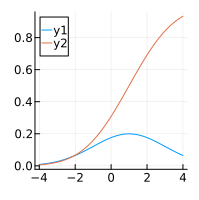

In [56]:
# If we want to get the pdf/cdf (e.g. for plotting), we need to give the function
# a range of x values to evaluate the pdf/cdf on

using Plots

x = -4:0.01:4
plot(x, pdf.(d, x), size=(200, 200))
plot!(x, cdf.(d, x))

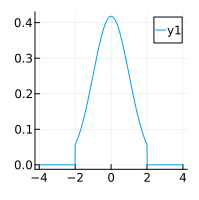

In [57]:
# To create truncated distributions, use:

lower_limit = -2
upper_limit = 2
d = truncated(Normal(), lower_limit, upper_limit)
plot(x, pdf.(d, x), size=(200, 200))

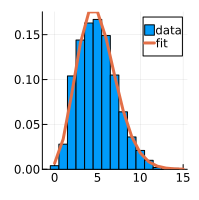

In [58]:
# We can also easily fit the parameters of a distribution to some data:

data = rand(Poisson(5), 1000)
d = fit(Poisson, data)

x = 0:15
histogram(data, normalize=:probability, bins=x .- 0.5, label="data", size=(200, 200))
plot!(x, pdf.(d, x), linewidth=3, label="fit")

## HypothesisTests.jl

https://juliastats.org/HypothesisTests.jl/stable/

This package lets us do all sorts of hypothesis tests like t-test, ANOVA, Mann-Whitney, etc

The documentation is amazing and can help you decide which test is best for your use case.

In [59]:
Pkg.add("HypothesisTests")
using HypothesisTests

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [61]:
# The example below is for a two sample t-test. You can obtain the p-value using the 'pvalue' function

x = randn(50)
y = randn(50) .+ 2
test = EqualVarianceTTest(x, y)
println(test)
println(pvalue(test))
dump(test)

Two sample t-test (equal variance)
----------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          -2.12028
    95% confidence interval: (-2.505, -1.736)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-17

Details:
    number of observations:   [50,50]
    t-statistic:              -10.940732380297383
    degrees of freedom:       98
    empirical standard error: 0.19379692788875252

1.1134372690323597e-18
EqualVarianceTTest
  n_x: Int64 50
  n_y: Int64 50
  xbar: Float64 -2.1202803241546317
  df: Int64 98
  stderr: Float64 0.19379692788875252
  t: Float64 -10.940732380297383
  μ0: Int64 0


### EXERCISE 2

Identify for which subjects the mean of the data from `experiment1` and `experiment2` is statistically significantly different (assume unequal variance).

In [ ]:
df = CSV.read("data/data_.csv", DataFrame)

##### TODO: CODE BELOW

##### TODO: CODE ABOVE

# INTERACTING WITH OTHER LANGUAGES

## PythonCall.jl

https://juliapy.github.io/PythonCall.jl/stable/

CondaPkg.jl is used to install python packages (https://github.com/JuliaPy/CondaPkg.jl)

In [66]:
Pkg.add(["PythonCall", "CondaPkg"])
using PythonCall, CondaPkg

   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
  [992eb4ea] + CondaPkg v0.2.22
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [68]:
# You can use 'pyimport' to import python packages/your own Python functions

CondaPkg.add("matplotlib")

plt = pyimport("matplotlib.pyplot")
x = range(0;stop=2*pi,length=1000); y = sin.(3*x + 4*cos.(2*x));
plt.plot(x, y, color="red", linewidth=2.0, linestyle="--")
plt.show()

    CondaPkg Found dependencies: /Users/jeroen/.julia/environments/v1.10/CondaPkg.toml
    CondaPkg Found dependencies: /Users/jeroen/.julia/packages/PythonCall/S5MOg/CondaPkg.toml
    CondaPkg Dependencies already up to date


Python: None

In [81]:
# You can run python code directly in Julia using 'pyexec'
# PRINT DOES NOT SHOW OUTPUT IN JUPYTER NOTEBOOK

fib(x) = pyexec("""
def fib(n):
    a, b = 0, 1
    while a < n:
        print(a, end=' ')
        a, b = b, a+b
    print()
fib(y)
""", Main, (y=x,))

fib(10)

## RCall.jl

https://juliainterop.github.io/RCall.jl/stable/

In [82]:
Pkg.add("RCall")
Pkg.build("RCall")
using RCall

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
    Building Conda → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/51cab8e982c5b598eea9c8ceaced4b58d9dd37c9/build.log`
    Building RCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/846b2aab2d312fda5e7b099fc217c661e8fae27e/build.log`


In [83]:
# Place R before the string of R code to run it

b = [1, 2, 3];
R"a <- $b"

RObject{IntSxp}
[1] 1 2 3


## MATLAB.jl

https://github.com/JuliaInterop/MATLAB.jl

In [ ]:
# # DOES NOT WORK ON APPLE SILICON (M1-3 chips)
# Pkg.add("MATLAB")
# Pkg.build("MATLAB")
# using MATLAB
# # You can use 'mxcall' to call existing/custom MATLAB functions
# # Otherwise, you can use mat in front of a string of MATLAB code
# mat"a=[0 1; 1 0]"